# Security and Privacy Implications Part 2 (Payment perspective)
In this notebook, we analyze the impact of the channel linking and lightning node clustering.
We do so by calculating the shares of capacity controlled by the largest entities, and analyzing the 
impact of griefing attacks, and the effects on the network structure, routable capacity and payment success when assuming entire entities are taken offline.
1. Data
2. Compute attack potential for paths
3. Extract Wormhole Statistics
4. Extract Value Privacy Statistics
5. Extract Relationship Anonymity Statistics
6. Plot combined version of value privacy and relationship anonymity

In [1]:
import sys
sys.path.append("..")

# input files
from utils import alias_address_clusters_csv_file, snapshot_csv_file

import pandas as pd
from plotnine import *
from mizani.formatters import percent_format

from igraph import *
from tqdm import tqdm

from utils import make_cluster_aliases, results_folder

theme_publication = theme_bw() + theme(text=element_text(family="cmr10", size=12, color="black"),
                                       axis_title=element_text(size=14))

# 1. Data
In this section, we load a lightning snapshot, a lightning node clustering, and list of channels with identified funding nodes.

#### Inputs (made available):
- `snapshot_csv_file` This is a lightning network snapshot from September 9, 2020
- `alias_address_clusters_csv_file`

#### Outputs:
- Pandas pickle files with attack potential for each path with a minimum satoshi capacity (not made available due to size)
- The other outputs of this notebooks are plots

Please be aware that running all cells some might take several hours to complete, look for the \*\*WARNING** comment in the cells).

In [2]:
clusters = pd.read_csv(alias_address_clusters_csv_file)
cluster_names = make_cluster_aliases(clusters)

# 2. Compute attack potential for paths
Here, a compute intensive script is run that determines for all possible pairs of nodes the cheapest path, and whether each path is susceptible to:

- the wormhole attack
- an attack on value privacy
- an attack on relationship anonymity

given a list of clustered lightning nodes.

Computing this takes several hours. A minimum of 64GB of RAM is required.

The script needs to be run with varying satoshi amounts.
If you have the resources, run the script in parallel from terminals.

In [3]:
# Use the following as parameters for the script.
print(snapshot_csv_file)
print(alias_address_clusters_csv_file)
print(results_folder)

../../data/level_2/lnsnapshot2020-09-09.csv
../../data/results/alias_address_clusters.csv
../../data/results/


In [ ]:
# **WARNING**, this may take several hours
%run computePathInfos.py ../../data/level_2/lnsnapshot2020-09-09.csv ../../data/results/alias_address_clusters.csv 1000
%run computePathInfos.py ../../data/level_2/lnsnapshot2020-09-09.csv ../../data/results/alias_address_clusters.csv 10000
%run computePathInfos.py ../../data/level_2/lnsnapshot2020-09-09.csv ../../data/results/alias_address_clusters.csv 100000
%run computePathInfos.py ../../data/level_2/lnsnapshot2020-09-09.csv ../../data/results/alias_address_clusters.csv 1000000

In [5]:
def getColumnStats(dataDF, column, label = None):
    tqdm.pandas()
    entities = dataDF[dataDF[column].progress_apply(len) > 0][column].apply(lambda x: x[0])
    entity_counts = entities.groupby(entities).count().sort_values(ascending = False)
    entity_counts.index.rename("cluster_id", inplace=True)

    entity_counts_DF = pd.DataFrame(entity_counts)
    entity_counts_DF['fraction'] = entity_counts_DF[column] / len(dataDF)
    entity_counts_DF['cusum'] = entity_counts_DF[column].cumsum() / len(dataDF)
    entity_counts_DF.reset_index(inplace = True)
    entity_counts_DF.loc[-1] = [-1, 0, 0, 0]  # adding a row
    entity_counts_DF.index = entity_counts_DF.index + 1  # shifting index
    entity_counts_DF.sort_index(inplace=True) 
    
    if(label is not None):
        entity_counts_DF['label'] = label
    
    return(entity_counts_DF)

In [ ]:
%%time
# **WARNING**, this may take about 15 minutes
value_privacy_results = list()
wormhole_results = list()
relationship_anonymity_results = list()
for amount in [str(10**i) for i in range(3,7)]:
    file = results_folder + "pathInfos2020-09-09-"+str(amount)+"-sats.pkl"
    print("On",file)
    data = pd.read_pickle(file)
    value_privacy_results.append(getColumnStats(data, "value_privacy", amount))
    wormhole_results.append(getColumnStats(data, "wormhole", amount))
    relationship_anonymity_results.append(getColumnStats(data, "relationship_anonymity", amount))

    del(data)

# 3. Extract wormhole statistics and plot
Here we extract the computed wormhole statistics and plot the result.

In [27]:
wormhole_stats = pd.concat(res.reset_index() for res in wormhole_results)
wormhole_stats = wormhole_stats.merge(cluster_names.rename(columns={"cluster":"cluster_id"}), how="left")
wormhole_stats = wormhole_stats.rename(columns={"index":"position"})
wormhole_stats.head()

,position,cluster_id,wormhole,fraction,cusum,label,cluster_size,alias
0,0,-1,0,0.000000,0.000000,1000,NaN,NaN
1,1,100,82485,0.001559,0.001559,1000,2.0,rompert.com
2,2,183,17688,0.000334,0.001893,1000,88.0,nan
3,3,210,16148,0.000305,0.002199,1000,3.0,2MASS JO253-140...
4,4,165,14536,0.000275,0.002473,1000,2.0,02bfe54c7b2ce6f...


/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 5 x 4 in image.
/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/wormholes.pdf


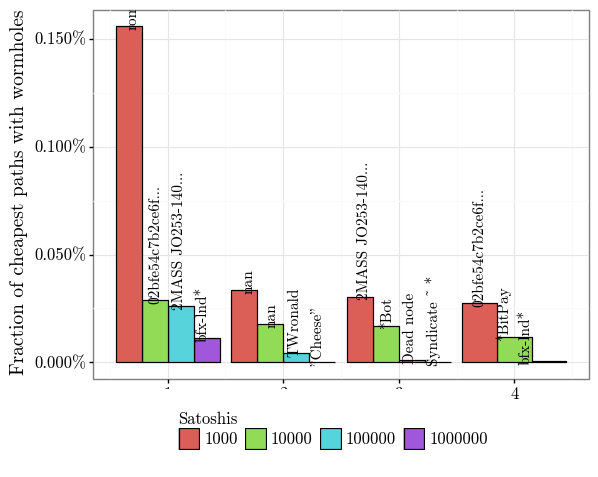

<ggplot: (8776105297478)>

In [13]:
# Figure 9
# Note that the legend and some of the labels of this plot have been improved manually in the paper itself
plot_wormhole_stats = wormhole_stats[(wormhole_stats.position <= 4) & (wormhole_stats.cluster_id > -1)]
plot = ggplot(plot_wormhole_stats) +\
geom_bar(aes(x="position", y="fraction", fill="label"), color="black", stat="identity", position="dodge") +\
geom_text(data=plot_wormhole_stats[(plot_wormhole_stats.label == "1000")],
          mapping=aes(x="position", y="fraction", label="alias"), angle=90, va="baseline", nudge_x=-0.3) +\
geom_text(data=plot_wormhole_stats[(plot_wormhole_stats.label == "10000")],
          mapping=aes(x="position", y="fraction", label="alias"), angle=90, va="baseline", nudge_x=-0.1) +\
geom_text(data=plot_wormhole_stats[(plot_wormhole_stats.label == "100000")],
          mapping=aes(x="position", y="fraction", label="alias"), angle=90, va="baseline", nudge_x=0.1) +\
geom_text(data=plot_wormhole_stats[(plot_wormhole_stats.label == "1000000")],
          mapping=aes(x="position", y="fraction", label="alias"), angle=90, va="baseline", nudge_x=0.3) +\
scale_y_continuous(labels=percent_format()) +\
scale_x_continuous(breaks=[1,2,3,4]) +\
labs(x="Top entities", y="Fraction of cheapest paths with wormholes", fill="Satoshis") +\
theme_publication +\
theme(legend_position="bottom")

plot.save("wormholes.pdf", width=5, height=4)
plot


# 4. Extract value privacy statistics

In [14]:
vp_stats = pd.concat(res.reset_index() for res in value_privacy_results)
vp_stats = vp_stats.merge(cluster_names.rename(columns={"cluster":"cluster_id"}), how="left")
vp_stats = vp_stats.rename(columns={"index":"position"})
vp_stats.sort_values("fraction", ascending=False).head()

,position,cluster_id,value_privacy,fraction,cusum,label,cluster_size,alias
294,1,93,2742032,0.384769,0.384769,1000000,26.0,LNBIG.com [*
106,1,93,12356777,0.254829,0.254829,10000,26.0,LNBIG.com [*
211,1,93,7346076,0.236397,0.236397,100000,26.0,LNBIG.com [*
1,1,93,12386937,0.234140,0.234140,1000,26.0,LNBIG.com [*
212,2,100,5625616,0.181032,0.417429,100000,2.0,rompert.com


# 5. Extraction relationship anonymity statistics

In [28]:
ra_stats = pd.concat(res.reset_index() for res in relationship_anonymity_results)
ra_stats = ra_stats.merge(cluster_names.rename(columns={"cluster":"cluster_id"}), how="left")
ra_stats = ra_stats.rename(columns={"index":"position"})
ra_stats.sort_values("fraction", ascending=False).head()
ra_stats.head()

,position,cluster_id,relationship_anonymity,fraction,cusum,label,cluster_size,alias
0,0,-1,0,0.000000,0.000000,1000,NaN,NaN
1,1,93,2585779,0.048877,0.048877,1000,26.0,LNBIG.com [*
2,2,100,480325,0.009079,0.057956,1000,2.0,rompert.com
3,3,0,239089,0.004519,0.062475,1000,65.0,*lnd-gar-nodl-it
4,4,44,152948,0.002891,0.065366,1000,2.0,CoinGate


# 6. Plot combined version of value privacy and relationship anonymity
Here, the previous results are combined into a single dataframe, to be used for plotting.

In [30]:
combined = vp_stats[["position", "label", "cusum", "alias"]].rename(columns={"cusum":"Value privacy"}).merge(
    ra_stats[["position", "label", "cusum", "alias"]].rename(columns={"cusum":"Relationship anonymity"}),
    on=["position", "label"])
combined[combined.position == 1]

,position,label,Value privacy,alias_x,Relationship anonymity,alias_y
1,1,1000,0.234140,LNBIG.com [*,0.048877,LNBIG.com [*
103,1,10000,0.254829,LNBIG.com [*,0.053135,LNBIG.com [*
205,1,100000,0.236397,LNBIG.com [*,0.073358,LNBIG.com [*
288,1,1000000,0.384769,LNBIG.com [*,0.155598,LNBIG.com [*


/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 5 x 4 in image.
/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: value_privacy_and_relationship_anonymity_le10.pdf


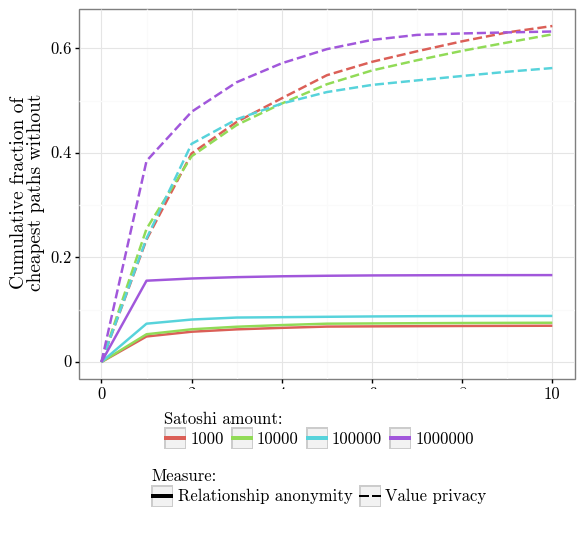

<ggplot: (8776105591312)>

In [31]:
# Figure 8
# Note that the legend and some of the labels of this plot have been improved manually in the paper itself
combined = pd.melt(combined, id_vars=["position", "label"], value_vars=["Value privacy", "Relationship anonymity"])
plot = ggplot(combined[combined.position <=10]) +\
geom_line(aes(x="position", y="value", color="label", linetype="variable"), size=1) +\
labs(x="Top entities", y="Cumulative fraction of\ncheapest paths without", linetype="Measure:", color="Satoshi amount:") +\
scale_x_continuous(breaks=range(0,11, 2)) +\
theme_publication +\
theme(legend_position="bottom")

plot.save("value_privacy_and_relationship_anonymity_le10.pdf", width=5, height=4) 
plot